# Machine Learning Exercise 7 - K-Means Clustering & PCA


In this exercise we will use K-means clustering to compress an image. We'll start with a simple 2D data set to see how K-means works, then we'll apply it to image compression. We'll also experiment with principal component analysis and see how it can be used to find a low-dimensional representation of images of faces.



## K-means clustering

K-means clustering is an iterative, unsupervised clustering algorithm that groups similar instances together into the same clusters. The algorithm starts by guessing the initial centroids for each cluster, and then repeatedly assigns instances to the nearest cluster and re-computes the centroid of that cluster.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

In [4]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

We fill first test the function using the test case provided in the exercise.

In [5]:
data = loadmat('ex7_data/ex7/ex7data2.mat')
X = data['X']
initial_centroids = initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

array([ 0.,  2.,  1.])

Next we need a function to compute the centroid of a cluster. The centroid is simply the mean of all of the examples currently assigned to the cluster.

In [7]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [8]:
compute_centroids(X, idx, 3)


array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

This output also matches the expected values from the exercise. So far so good

In [10]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [11]:
idx, centroids = run_k_means(X, initial_centroids, 10)


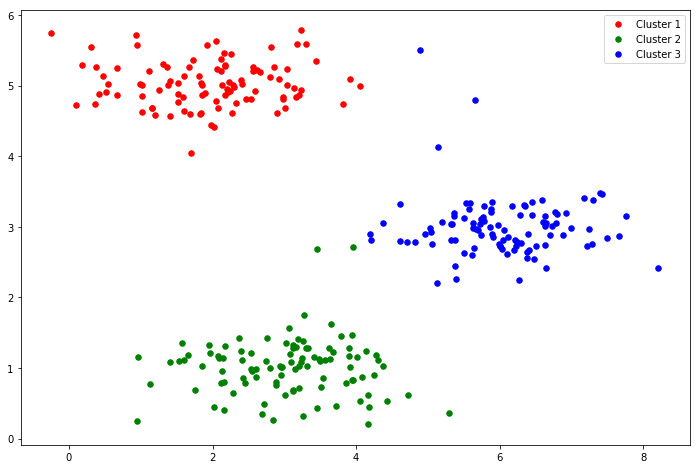

In [12]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()


We're tasked with creating a function that selects random examples and uses them as the initial centroids.

In [13]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

In [14]:
init_centroids(X, 3)


array([[ 4.70775773,  2.78710869],
       [ 4.01714917,  1.16070647],
       [ 2.68499376,  0.35344943]])

## K-means for image compression

Our next task is to apply K-means to image compression. We are trying to find a small number of colors that are most representative of the image, and use them to map the original 24-bit colors to a lower dimension. 


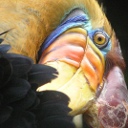

In [15]:
from IPython.display import Image
Image(filename='ex7_data/ex7/bird_small.png')


In [17]:
image_data = loadmat('ex7_data/ex7/bird_small.mat') # loading the raw pixel data
image_data

{'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ..., 
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ..., 
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ..., 
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ..., 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ..., 
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ..., 
         [ 80,  38,  40],
         [ 68,  39,  40],
         [ 59,  43,  42]],
 
        [[ 15,  19,  19],
         [ 20,  20,  18],
         [ 18,  19,  17],
         ..., 
         [ 65,  43

In [18]:
A = image_data['A']
A.shape

(128, 128, 3)

Now we will pre-process the data before applying the K-means method. 


In [19]:
# normalize value ranges
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

In [23]:
# random initialization of the centroids
initial_centroids = init_centroids(X, 16)

# run the algorithm
idx, centroids = run_k_means(X, initial_centroids, 10)

# get the closest centroids one last time
idx = find_closest_centroids(X, centroids)

# map each pixel to the centroid value
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [21]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

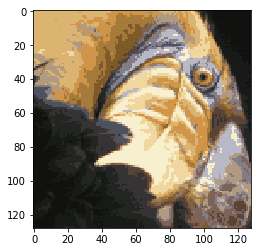

In [22]:
plt.imshow(X_recovered)


# Principle Components Analysis (PCA)

PCA is a linear transformation that finds the "principal components", or directions of greatest variance, in a data set.


In [25]:
data = loadmat('ex7_data/ex7/ex7data1.mat')
data

{'X': array([[ 3.38156267,  3.38911268],
        [ 4.52787538,  5.8541781 ],
        [ 2.65568187,  4.41199472],
        [ 2.76523467,  3.71541365],
        [ 2.84656011,  4.17550645],
        [ 3.89067196,  6.48838087],
        [ 3.47580524,  3.63284876],
        [ 5.91129845,  6.68076853],
        [ 3.92889397,  5.09844661],
        [ 4.56183537,  5.62329929],
        [ 4.57407171,  5.39765069],
        [ 4.37173356,  5.46116549],
        [ 4.19169388,  4.95469359],
        [ 5.24408518,  4.66148767],
        [ 2.8358402 ,  3.76801716],
        [ 5.63526969,  6.31211438],
        [ 4.68632968,  5.6652411 ],
        [ 2.85051337,  4.62645627],
        [ 5.1101573 ,  7.36319662],
        [ 5.18256377,  4.64650909],
        [ 5.70732809,  6.68103995],
        [ 3.57968458,  4.80278074],
        [ 5.63937773,  6.12043594],
        [ 4.26346851,  4.68942896],
        [ 2.53651693,  3.88449078],
        [ 3.22382902,  4.94255585],
        [ 4.92948801,  5.95501971],
        [ 5.79295774,  

Ok let's plot this first.

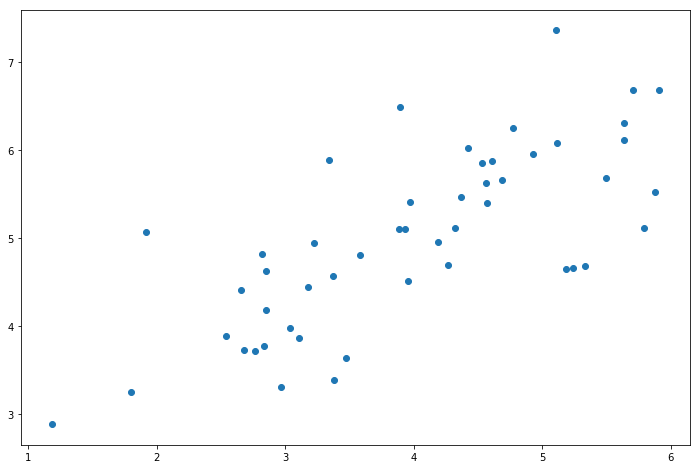

In [26]:
X = data['X']

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:, 0], X[:, 1])

The algorithm for PCA is fairly simple. After ensuring that the data is normalized, the output is simply the singular value decomposition of the covariance matrix of the original data.

In [27]:
def pca(X):
    # normalize the features
    X = (X - X.mean()) / X.std()
    
    # compute the covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    
    # perform SVD
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

In [28]:
U, S, V = pca(X)
U, S, V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([ 1.43584536,  0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

Now that we have the principal components (matrix U), we can now project the original data into a lower-dimensional space. Our function will select only the top K components, reducing the number of dimensions.



In [29]:
def project_data(X, U, k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

In [30]:
Z = project_data(X, U, 1)
Z


matrix([[-4.74689738],
        [-7.15889408],
        [-4.79563345],
        [-4.45754509],
        [-4.80263579],
        [-7.04081342],
        [-4.97025076],
        [-8.75934561],
        [-6.2232703 ],
        [-7.04497331],
        [-6.91702866],
        [-6.79543508],
        [-6.3438312 ],
        [-6.99891495],
        [-4.54558119],
        [-8.31574426],
        [-7.16920841],
        [-5.08083842],
        [-8.54077427],
        [-6.94102769],
        [-8.5978815 ],
        [-5.76620067],
        [-8.2020797 ],
        [-6.23890078],
        [-4.37943868],
        [-5.56947441],
        [-7.53865023],
        [-7.70645413],
        [-5.17158343],
        [-6.19268884],
        [-6.24385246],
        [-8.02715303],
        [-4.81235176],
        [-7.07993347],
        [-5.45953289],
        [-7.60014707],
        [-4.39612191],
        [-7.82288033],
        [-3.40498213],
        [-6.54290343],
        [-7.17879573],
        [-5.22572421],
        [-4.83081168],
        [-7

We can also recover the original data by reversing the steps of PCA.

In [32]:
def recover_data(Z, U, k):
    U_reduced = U[:,:k]
    return np.dot(Z, U_reduced.T)

In [35]:
X_recovered = recover_data(Z, U, 1)
X_recovered

matrix([[ 3.76152442,  2.89550838],
        [ 5.67283275,  4.36677606],
        [ 3.80014373,  2.92523637],
        [ 3.53223661,  2.71900952],
        [ 3.80569251,  2.92950765],
        [ 5.57926356,  4.29474931],
        [ 3.93851354,  3.03174929],
        [ 6.94105849,  5.3430181 ],
        [ 4.93142811,  3.79606507],
        [ 5.58255993,  4.29728676],
        [ 5.48117436,  4.21924319],
        [ 5.38482148,  4.14507365],
        [ 5.02696267,  3.8696047 ],
        [ 5.54606249,  4.26919213],
        [ 3.60199795,  2.77270971],
        [ 6.58954104,  5.07243054],
        [ 5.681006  ,  4.37306758],
        [ 4.02614513,  3.09920545],
        [ 6.76785875,  5.20969415],
        [ 5.50019161,  4.2338821 ],
        [ 6.81311151,  5.24452836],
        [ 4.56923815,  3.51726213],
        [ 6.49947125,  5.00309752],
        [ 4.94381398,  3.80559934],
        [ 3.47034372,  2.67136624],
        [ 4.41334883,  3.39726321],
        [ 5.97375815,  4.59841938],
        [ 6.10672889,  4.700

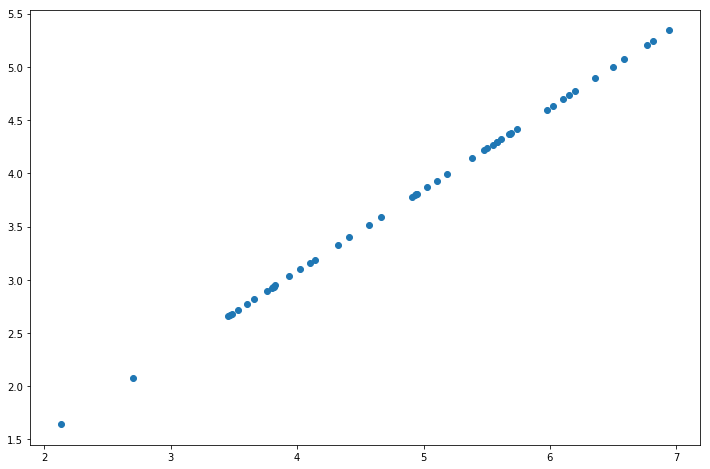

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter([X_recovered[:, 0]], [X_recovered[:, 1]])


The projection axis for the first principal component was basically a diagonal line through the data set. When we reduced the data to one dimension, we lost the variations around that diagonal line, so in the plot everything falls along that diagonal.

Our last task in this exercise is to apply PCA to images of faces. The same methods can be used to extract the key features of an image. 

In [56]:
faces = loadmat('ex7_data/ex7/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

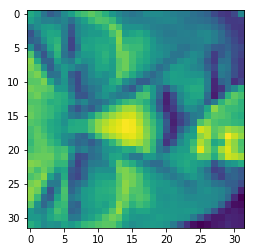

In [61]:
face = np.reshape(X[8,:], (32, 32))
plt.imshow(face)


Our next step is to run PCA on the faces data set and take the top 100 principal components.



In [62]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

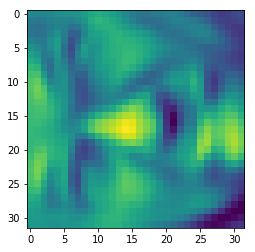

In [63]:
X_recovered = recover_data(Z, U, 100)
face = np.reshape(X_recovered[8,:], (32, 32))
plt.imshow(face)

Observe that we lost some detail, though not as much as you might expect for a 10x reduction in the number of dimensions.

